In [1]:
import pandas as pd 
import numpy as np 
import talib as tb
import yfinance as yf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Correlation Matrix

In [2]:
result = pd.read_csv(r'../data/cryptoInd/matic_ind.csv', index_col='Date')

## Scaling

In [5]:
scaled_df = result.copy()
scaler_std = StandardScaler()
scaled_feat = scaler_std.fit_transform(result)
scaled_df = pd.DataFrame(scaled_feat, index = result.index, columns=result.columns)
scaled_df.head()

,adj_close,close,low,high,open,volume,SMA30,CMA30,EMA30,adx,...,bb_high,macd,macdsignal,macdhist,rsi,stdev,slowk,slowd,dollar_close,sp500_close
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-31,-0.716651,-0.716651,-0.716567,-0.717222,-0.717301,-0.496105,-0.711855,-0.643263,-0.717091,4.305156,...,-0.710270,-0.070349,-0.058000,-0.051844,0.624137,-0.593876,-0.906454,-1.212312,0.793306,-1.413343
2019-06-03,-0.720873,-0.720873,-0.717444,-0.719745,-0.716875,-0.520850,-0.710651,-0.639649,-0.717353,3.733379,...,-0.712618,-0.090705,-0.075261,-0.065478,0.077053,-0.611663,-1.122106,-0.786645,0.597637,-1.425069
2019-06-04,-0.718060,-0.718060,-0.718598,-0.718631,-0.718132,-0.482084,-0.711380,-0.638388,-0.717214,3.552306,...,-0.714060,-0.094557,-0.081057,-0.060835,0.382159,-0.616057,-0.726452,-0.830542,0.577942,-1.334441
2019-06-05,-0.715887,-0.715887,-0.716249,-0.716568,-0.715289,-0.460181,-0.711972,-0.636933,-0.716816,3.413187,...,-0.715912,-0.096166,-0.086041,-0.051569,0.602692,-0.623226,0.201363,-0.591481,0.659308,-1.299188
2019-06-06,-0.714737,-0.714737,-0.713373,-0.714529,-0.713252,-0.460413,-0.711834,-0.635419,-0.716321,3.310810,...,-0.715761,-0.096980,-0.090206,-0.042191,0.716876,-0.623039,1.212180,0.255871,0.577297,-1.272471


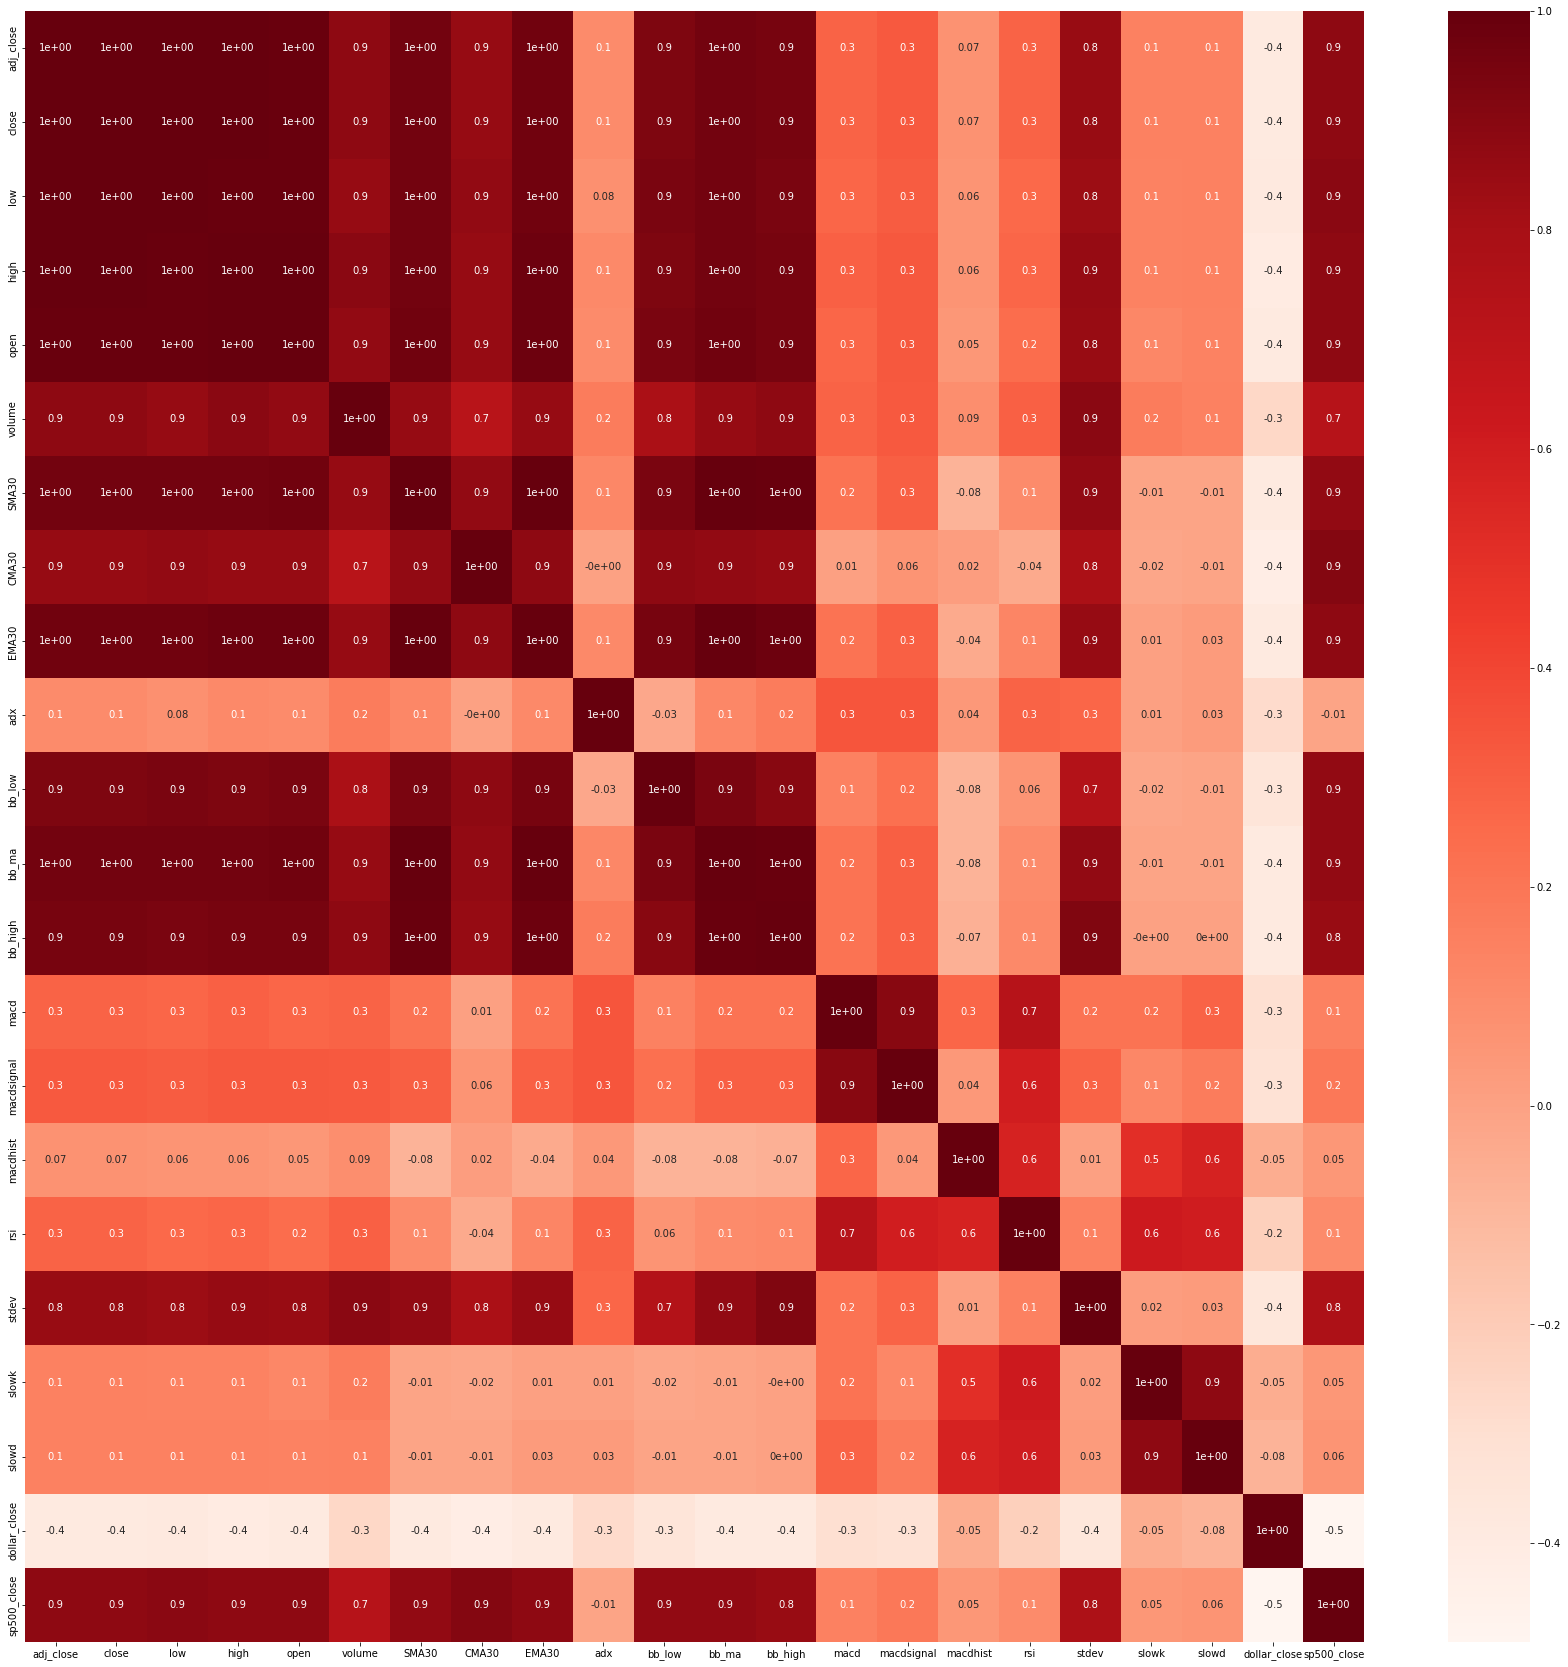

In [6]:
# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(scaled_df.corr(method="spearman"), decimals=2)

def cor_heatmap(cor):
    plt.figure(figsize=(30,30))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()


cor_heatmap(corr)

As we can see high, low, open, SMA30, EMA30 and the Bollinger Bands pretty much all tell the same information and are highly correlated. These variables will then be removed. 

In [128]:
scaled_df.columns

Index(['adj_close', 'close', 'low', 'high', 'open', 'volume', 'SMA30', 'CMA30',
       'EMA30', 'adx', 'bb_low', 'bb_ma', 'bb_high', 'macd', 'macdsignal',
       'macdhist', 'rsi', 'stdev', 'slowk', 'slowd', 'dollar_close',
       'sp500_close'],
      dtype='object')

In [7]:
scaled_df.drop(['low', 'open','SMA30', 'EMA30','CMA30','bb_low', 'bb_ma', 'bb_high', 'stdev', 'adj_close', 'macdsignal', 'volume', 'sp500_close'], axis=1, inplace=True)

# Timeseries CV and Sliding window 

## TimeSeries CV

In [130]:
scaled_df.columns

Index(['close', 'high', 'volume', 'CMA30', 'adx', 'macd', 'macdhist', 'rsi',
       'slowk', 'slowd', 'dollar_close', 'sp500_close'],
      dtype='object')

In [131]:
y_cv = result['close']
X_cv = scaled_df.drop(['close'], axis=1)

In [132]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(X_cv):
        X_train_cv, X_test_cv = X_cv[:len(train_index)], X_cv[len(train_index): (len(train_index)+len(test_index))]
        y_train_cv, y_test_cv = y_cv[:len(train_index)].values.ravel(), y_cv[len(train_index): (len(train_index)+len(test_index))].values.ravel()

## Hand-Made Sliding Window

In [136]:
y = result
y.reset_index(inplace=True)
X = scaled_df.drop(['close'], axis=1)
X.reset_index(inplace=True)
y['Date'] = pd.to_datetime(y['Date']).dt.date

In [137]:
def train_test_split_time_series(data, num_df, column_date):
    #data: data frame to split
    #num_df: number of differente splits
    #column_date: name of the column that has the Date info
    data[column_date] = pd.to_datetime(data[column_date]).dt.date
    date_split=[]
    max_date = data[column_date].max()
    min_date = data[column_date].min()
    range_date = max_date-min_date
    split_criteria = 0.2/(num_df-1)
    train = 0.6
    test = 0.8
    inicial = 0
    for i in range(num_df):
        list_to_add=[]
        list_to_add.append((min_date + range_date*inicial))
        list_to_add.append((min_date + range_date*train))
        list_to_add.append((min_date + range_date*test))
        train = train + split_criteria
        test = test + split_criteria
        inicial = inicial + split_criteria

        date_split.append(list_to_add)
    
    
    return date_split

In [138]:
def date_to_index(col_name, *args):
    for df in args:
        df.set_index(col_name, inplace = True)

## TimeBaseCV

In [9]:
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

# code from: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8"

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            #print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
            #      "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits

In [140]:
y_tbcv = result['close']
X_tbcv = scaled_df.drop(['close'], axis=1)

In [141]:
X_tbcv.reset_index(inplace=True)
X_tbcv['Date'] = pd.to_datetime(X_tbcv['Date'], format='%Y-%m-%d')

In [142]:
tscv = TimeBasedCV(train_period=100,
                   test_period=12,
                   freq='days')

for train_index, test_index in tscv.split(X_tbcv,date_column='Date'):
    data_train   = X_tbcv.loc[train_index]
    data_train.set_index('Date', inplace=True)
    target_train = y_tbcv.loc[train_index]
    data_test    = X_tbcv.loc[test_index]
    target_test  = y_tbcv.loc[test_index]
    data_test.set_index('Date', inplace=True)

    print("TRAIN: From"+ str(data_train.index.min())+" to "+str(data_train.index.max()))
    print("TEST: From"+ str(data_test.index.min())+" to "+str(data_test.index.max()))

# get number of splits
tscv.get_n_splits()

TRAIN: From2017-12-12 00:00:00 to 2018-03-21 00:00:00
TEST: From2018-03-22 00:00:00 to 2018-04-02 00:00:00
TRAIN: From2017-12-26 00:00:00 to 2018-04-02 00:00:00
TEST: From2018-04-03 00:00:00 to 2018-04-13 00:00:00
TRAIN: From2018-01-05 00:00:00 to 2018-04-13 00:00:00
TEST: From2018-04-16 00:00:00 to 2018-04-26 00:00:00
TRAIN: From2018-01-17 00:00:00 to 2018-04-26 00:00:00
TEST: From2018-04-27 00:00:00 to 2018-05-08 00:00:00
TRAIN: From2018-01-29 00:00:00 to 2018-05-08 00:00:00
TEST: From2018-05-09 00:00:00 to 2018-05-18 00:00:00
TRAIN: From2018-02-12 00:00:00 to 2018-05-18 00:00:00
TEST: From2018-05-21 00:00:00 to 2018-06-01 00:00:00
TRAIN: From2018-02-22 00:00:00 to 2018-06-01 00:00:00
TEST: From2018-06-04 00:00:00 to 2018-06-13 00:00:00
TRAIN: From2018-03-06 00:00:00 to 2018-06-13 00:00:00
TEST: From2018-06-14 00:00:00 to 2018-06-25 00:00:00
TRAIN: From2018-03-19 00:00:00 to 2018-06-25 00:00:00
TEST: From2018-06-26 00:00:00 to 2018-07-06 00:00:00
TRAIN: From2018-04-02 00:00:00 to 201

124

# Models

## Functions To Apply the Models 

In [10]:
# Models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [11]:
def show_results(df,X_train, X_test, y_train, y_test, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    preds = [y_test]
    count = 0
    # for each model passed as argument
    for arg in args:
        # applies the model
        model_fit = arg.fit(X_train, y_train)
        # predicts training
        y_pred_test = model_fit.predict(X_test)
        # evaluate predictions
        mae = mean_absolute_error(y_test, y_pred_test)
        mse = mean_squared_error(y_test, y_pred_test)
        r2 = r2_score(y_test, y_pred_test)
        preds.append(y_pred_test)
        # store the results in the right row
        df.iloc[count] = mae, mse, r2
        count+=1
    
    fig = px.line(X_test, x = X_test.index, y = preds)
    fig.show()
    return df

In [12]:
def avg_score(model, X, y, splits,split_method = 'tscv', train_period_split = 30,test_period_split=7):

    # create lists to store the results from the different models 
    mae_list = []
    mse_list = []
    r2_list = []
    flag = 0 # feat sel flag to not keep printing 

    if split_method == 'hmcv':
        X_tbcv = X.reset_index()
        X_tbcv['Date'] = pd.to_datetime(X_tbcv['Date'], format='%Y-%m-%d')                
        tscv = TimeBasedCV(train_period=train_period_split,
                        test_period=test_period_split,
                        freq='days')

        fig = make_subplots(rows=1, cols=1)
        fig2 = go.Figure()

        for train_index, test_index in tscv.split(X_tbcv,date_column='Date'):
                X_train   = X_tbcv.loc[train_index]
                y_train = y.loc[train_index]
                X_val    = X_tbcv.loc[test_index]
                y_val  = y.loc[test_index]
                X_train.set_index('Date', inplace=True)                
                X_val.set_index('Date', inplace=True)

                # applies the model 
                model_fit = model.fit(X_train, y_train)
                #predicts validation 
                y_pred_val = model_fit.predict(X_val)
                
                # prints metric results         
                #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)
                value_mae = mean_absolute_error(y_val, y_pred_val)
                value_mse = mean_squared_error(y_val, y_pred_val)
                value_r2 = r2_score(y_val, y_pred_val)
                # append the accuracies, the time and the number of iterations in the corresponding list
                mae_list.append(value_mae)
                mse_list.append(value_mse)
                r2_list.append(value_r2)

                #y_val_unscaled = scaler.inverse_transform(y_val)
                #y_pred_val_unscaled = scaler.inverse_transform(y_pred_val)

                #print(len(X_val), len(y_val), len(y_pred_val))
                real_name = 'real '+ str(X_val.index.min().day)+"-"+ str(X_val.index.min().month)+"-"+ str(X_val.index.min().year)+" to "\
                                   + str(X_val.index.max().day)+"-"+ str(X_val.index.max().month)+"-"+ str(X_val.index.max().year)
                pred_name = 'pred '+ str(X_val.index.min().day)+"-"+ str(X_val.index.min().month)+"-"+ str(X_val.index.min().year)+" to"\
                                   + str(X_val.index.max().day)+"-"+ str(X_val.index.max().month)+"-"+ str(X_val.index.max().year)+" "


                fig2.add_trace(go.Scatter(x=X_val.index, y=y_val, name=real_name, mode='lines',line=dict(color='green')))
                fig2.add_trace(go.Scatter(x=X_val.index, y=y_pred_val, name=pred_name, mode='lines', line=dict(color='red')))
                
                
        model_name = str(rf_se)+"Number of Splits: "+ str(tscv.get_n_splits())
        
        fig2.update_layout(dict(updatemenus=[
                                dict(
                                type = "buttons",
                                direction = "left",
                                buttons=list([
                                        dict(
                                        args=["visible", "legendonly"],
                                        label="Deselect All",
                                        method="restyle"
                                        ),
                                        dict(
                                        args=["visible", True],
                                        label="Select All",
                                        method="restyle"
                                        )
                                ]),
                                pad={"r": 10, "t": 10},
                                showactive=False,
                                x=1,
                                xanchor="right",
                                y=1.1,
                                yanchor="top"
                                ),
                        ]
                ))

        fig2.update_layout(height=1000, width=1000,
                title_text='model_name')
        fig2.show()     


        
    elif split_method == 'tscv':
        fig = make_subplots(rows=splits, cols=1)
        #Splitting to Training set and Test set
        timesplit= TimeSeriesSplit(n_splits=splits)
        flag = 1
        for train_index, test_index in timesplit.split(X):
                X_train, X_val = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
                y_train, y_val = y[:len(train_index)].values.ravel(), y[len(train_index): (len(train_index)+len(test_index))].values.ravel()
                # applies the model 
                model_fit = model.fit(X_train, y_train)
                #predicts validation 
                y_pred_val = model_fit.predict(X_val)
                
                # prints metric results         
                #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)
                value_mae = mean_absolute_error(y_val, y_pred_val)
                value_mse = mean_squared_error(y_val, y_pred_val)
                value_r2 = r2_score(y_val, y_pred_val)
                # append the accuracies, the time and the number of iterations in the corresponding list
                mae_list.append(value_mae)
                mse_list.append(value_mse)
                r2_list.append(value_r2)

                
                title_y = "Value from "+str(X_val.index.min())+" to "+str(X_val.index.max())
                 
                fig.add_trace(go.Scatter(x=X_val.index, y=y_val, name='real', mode='lines', line=dict(color="#0000ff")),
                row=flag,col=1)
                fig.add_trace(go.Scatter(x=X_val.index, y=y_pred_val, name='prediction', mode='lines', line=dict(color="#0000ff")),
                row=flag,col=1)
                fig.update_xaxes(title_text= title_y, row=flag, col=1, title_font_size=10)
                
                flag+=1
                
        model_name = str(rf_se)

        fig.update_layout(height=1000, width=1000,
                title_text=model_name)
        fig.show()

        
        
  
    avg_mae = round(np.mean(mae_list),3)
    std_mae = round(np.std(mae_list),2)
    avg_mse = round(np.mean(mse_list),3)
    std_mse = round(np.std(mse_list),2)
    avg_r2 = round(np.mean(r2_list),3)
    std_r2 = round(np.std(r2_list),2)

    return str(avg_mae) + '+/-' + str(std_mae),\
            str(avg_mse) + '+/-' + str(std_mse) , str(avg_r2) + '+/-' + str(std_r2)

## Random Forest

In [13]:
y = result['close']
X = scaled_df.drop(['close'], axis=1)

In [17]:
X.reset_index(inplace=True)

In [18]:
rf_se = RandomForestRegressor(random_state=10,criterion='squared_error')
rf_ae = RandomForestRegressor(random_state=10,criterion='absolute_error')
rf_poisson = RandomForestRegressor(random_state=10,criterion='poisson')


In [19]:
# passar X e y --> No X a Date deve ser index 
# retorna este grafico e os valores, o suposto do grafico é selecionarem aos bocados o que querem ver 
# o train period e test period sao em dias (neste caso 100 dias de train para 5 de teste)
avg_score(rf_se, X, y, 5, 'hmcv', train_period_split=100, test_period_split=5)

KeyError: "None of [Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,\n            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,\n            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,\n            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,\n            68],\n           dtype='int64', name='Date')] are in the [index]"

In [54]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['squared','absolute', 'poisson'])
show_results(df, X_train_cv, X_test_cv, y_train_cv, y_test_cv,rf_se, rf_ae,rf_poisson)

,MAE,MSE,R2
squared,86.059531,12527.516019,0.9526
absolute,81.274506,11598.372272,0.956115
poisson,1284.953549,1861840.898061,-6.044646


In [55]:
rf_se5 = RandomForestRegressor(random_state=10,criterion='squared_error', max_depth=5,n_estimators=300)
rf_se20 = RandomForestRegressor(random_state=10,criterion='squared_error', max_depth=20, n_estimators=2000)
rf_se50 = RandomForestRegressor(random_state=10,criterion='squared_error', max_depth=50 ,n_estimators=3000)


In [56]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['300','2000', '3000'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv,rf_se5, rf_se20,rf_se50)

,MAE,MSE,R2
300,87.586596,13429.166272,0.949188
2000,81.06542,11494.129194,0.95651
3000,80.624902,11379.924481,0.956942


## Gradient Boost

In [57]:
gb_mae = GradientBoostingRegressor(random_state = 10 , loss='absolute_error', n_estimators = 130)
gb_mse = GradientBoostingRegressor(random_state = 10 , criterion='squared_error', n_estimators = 130)


In [58]:
len(X_train_cv)

1000

In [59]:
len(X_test_cv)

99

<AxesSubplot:title={'center':'Feature Importances'}>

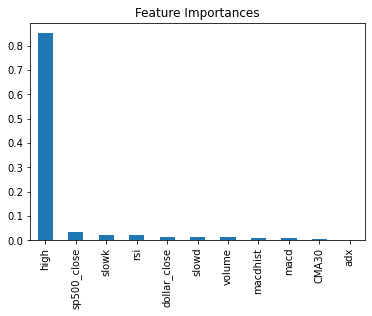

In [60]:
# applies the model
model_fit = gb_mae.fit(X_train_cv, y_train_cv)
# predicts training
y_pred_test = model_fit.predict(X_test_cv)
# evaluate predictions
mae = mean_absolute_error(y_test_cv, y_pred_test)
mse = mean_squared_error(y_test_cv, y_pred_test)
r2 = r2_score(y_test_cv, y_pred_test)

feat_imp = pd.Series(model_fit.feature_importances_, X_train_cv.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

In [61]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['mae','mse'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv,gb_mae, gb_mse)

,MAE,MSE,R2
mae,175.266375,75003.458628,0.716209
mse,114.060772,19783.790382,0.925144


In [62]:
gb_200 = GradientBoostingRegressor(random_state = 10 , criterion='squared_error', n_estimators = 55)
gb_500 = GradientBoostingRegressor(random_state = 10 , criterion='squared_error', n_estimators = 80)
gb_1500 = GradientBoostingRegressor(random_state = 10 , criterion='squared_error', n_estimators = 100)
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['55','80', '100'])
show_results(df, X_train_cv, X_test_cv, y_train_cv, y_test_cv,gb_200, gb_500, gb_1500)

,MAE,MSE,R2
55,97.186424,14361.702609,0.94566
80,106.824322,17629.460462,0.933295
100,111.439669,19081.472546,0.927801


In [63]:
gb_5 = GradientBoostingRegressor(random_state = 10 ,  criterion='squared_error', n_estimators = 55,min_samples_split=5)
gb_10 = GradientBoostingRegressor(random_state = 10 ,  criterion='squared_error', n_estimators = 55,min_samples_split=10)
gb_50 = GradientBoostingRegressor(random_state = 10 , criterion='squared_error', n_estimators = 55,min_samples_split=50)
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['5','10', '50'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv,gb_5, gb_10,gb_50)

,MAE,MSE,R2
5,98.269546,14700.653448,0.944377
10,98.877467,14940.591887,0.943469
50,101.278893,15927.37606,0.939736


In [64]:
gb_01 = GradientBoostingRegressor(random_state = 10 ,  criterion='squared_error', n_estimators = 55,min_samples_split=10, learning_rate=0.05)
gb_005 = GradientBoostingRegressor(random_state = 10 , criterion='squared_error', n_estimators = 55,min_samples_split=10, learning_rate=0.1)
gb_02 = GradientBoostingRegressor(random_state = 10 ,  criterion='squared_error', n_estimators = 55,min_samples_split=10, learning_rate=0.2)
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['0.05','0.1', '0.2'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv,gb_005, gb_01, gb_02)

,MAE,MSE,R2
0.05,98.877467,14940.591887,0.943469
0.1,124.757789,21537.396574,0.918509
0.2,146.987284,29873.728398,0.886967


In [65]:
avg_score(gb_005, X, y, 5, 'hmcv', train_period_split=100, test_period_split=5)

('53.424+/-86.48', '12715.911+/-44407.25', '-14.049+/-49.22')

## XGBoost

In [66]:
xgb_mae = XGBRegressor(random_state = 10 , criterion='absolute_error', n_estimators = 130)
xgb_mse = XGBRegressor(random_state = 10 , criterion='squared_error', n_estimators = 130)

<AxesSubplot:title={'center':'Feature Importances'}>

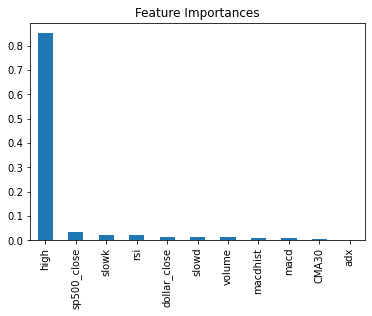

In [67]:
# applies the model
model_fit = gb_mae.fit(X_train_cv, y_train_cv)
# predicts training
y_pred_test = model_fit.predict(X_test_cv)
# evaluate predictions
mae = mean_absolute_error(y_test_cv, y_pred_test)
mse = mean_squared_error(y_test_cv, y_pred_test)
r2 = r2_score(y_test_cv, y_pred_test)

feat_imp = pd.Series(model_fit.feature_importances_, X_train_cv.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

In [68]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['mae','mse'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv,xgb_mae, xgb_mse)

[13:55:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:55:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,MAE,MSE,R2
mae,109.215761,18401.290728,0.930375
mse,109.215761,18401.290728,0.930375


In [69]:
xgb_gbtree = XGBRegressor(random_state = 10 , booster= 'gbtree', n_estimators = 130)

xgb_gblinear = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130)

xgb_dart = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130)

In [70]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['gbtree','gblinear','dart'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv,xgb_gbtree, xgb_gblinear,xgb_dart )

,MAE,MSE,R2
gbtree,109.215761,18401.290728,0.930375
gblinear,120.612199,20545.40839,0.922262
dart,109.215744,18401.286579,0.930375


In [71]:
xgb_true = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = True)

xgb_false = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False)

In [72]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['True', 'False'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv, xgb_true,xgb_false )

,MAE,MSE,R2
True,129.383468,23200.749822,0.912215
False,100.834672,15304.021361,0.942094


In [73]:
xgb_false = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False)

xgb_true = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True)

In [74]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['True', 'False'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv, xgb_true,xgb_false )

,MAE,MSE,R2
True,103.435589,15953.003798,0.939639
False,110.269664,17684.797449,0.933086


In [75]:
xgb_005 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False,eta = 0.05)

xgb_01 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False,eta = 0.1)

xgb_03 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False,eta = 0.3)

xgb_05 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False,eta = 0.5)

In [76]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['0,05', '0,1', '0,3', '0,5'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv, xgb_005,xgb_01, xgb_03, xgb_05 )

,MAE,MSE,R2
"0,05",332.926208,160426.379363,0.392995
"0,1",376.226945,189918.312145,0.281406
"0,3",220.880097,64146.470592,0.757289
"0,5",121.537652,20813.549439,0.921248


In [78]:
avg_score(xgb_true, X, y, 5, 'hmcv', train_period_split=100, test_period_split=5)

('56.085+/-71.48', '9269.175+/-27904.91', '-59.136+/-203.21')

# LSTM

In [83]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [159]:
y = scaled_df['close']
X = scaled_df.drop(['close'], axis=1)

In [161]:
X.reset_index(inplace=True)

In [164]:
X.drop('Date', axis=1, inplace=True)

In [165]:
X

,high,volume,CMA30,adx,macd,macdhist,rsi,slowk,slowd,dollar_close,sp500_close
0,-0.354764,-0.703342,-0.546662,0.654631,0.493272,0.108479,1.905817,0.839447,0.454673,-0.273601,-1.020815
1,-0.285521,-0.759625,-0.506423,0.834458,0.646172,0.481387,2.096824,1.577599,1.012913,-0.494745,-1.022653
2,-0.281605,-0.820002,-0.469362,1.005256,0.750345,0.654174,1.998605,1.365336,1.354209,-0.474672,-1.038463
3,-0.324361,-0.911292,-0.435805,1.056771,0.810958,0.680174,1.834188,1.107175,1.450618,-0.324119,-1.003751
4,-0.242806,-0.869161,-0.325981,1.313725,1.004357,0.778813,2.256231,1.166785,1.108845,-0.460955,-0.982823
...,...,...,...,...,...,...,...,...,...,...,...
1094,1.529734,0.067625,2.612355,-1.167335,-0.291331,-1.194162,-0.134580,-0.032460,-0.529192,2.029503,1.601628
1095,1.554782,0.187126,2.618415,-1.231151,-0.302346,-0.983039,-0.225345,0.852291,0.114590,1.846500,1.597603
1096,1.566669,0.636867,2.624197,-1.231543,-0.394967,-1.024394,-0.522911,0.411450,0.435560,1.912408,1.501651
1097,1.453194,0.293238,2.629904,-1.218398,-0.486204,-1.053911,-0.594595,-0.462537,0.280690,2.112808,1.323895


In [114]:
X_train = []

In [170]:
result = pd.read_csv(r'../data/cryptoInd/eth_ind.csv')

In [184]:
result['Date'] = pd.to_datetime(result.Date,format='%Y-%m-%d')
result.index = result['Date']
#plt.figure(figsize=(16,8))
#plt.plot(dataset['Volume'], label='Amount of Stocks')

dataset = result.sort_index(ascending=True, axis=0)
dataset2 = pd.DataFrame(index=range(0,len(dataset)),columns=['Date', 'close'])
for i in range(0,len(dataset)):
    dataset2['Date'][i] = dataset['Date'][i]
    dataset2['close'][i] = dataset['close'][i]
    
dataset2.index = dataset2.Date
dataset2.drop('Date', axis=1, inplace = True)

dataset3 = dataset2.values 

train = dataset3[0:1000, :]
valid = dataset3[1000:, :]
#print(valid)

In [185]:
# puts everything between (0,1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset3)
#print(scaled_data)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))



In [186]:
model = Sequential()
model.add(LSTM( units=1000, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=1000))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

940/940 - 12411s - loss: 0.1216 - 12411s/epoch - 13s/step


In [187]:
len(scaled_data)

1099

In [190]:
X_test = []
for i in range(60,len(valid)):
    X_test.append(scaled_data[i-60:i,0])
X_test = np.array(X_test)
print(len(X_test))

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
#print(X_test.shape)

train = dataset2[:200]
valid = dataset2[200:]
valid['Predictions'] = closing_price
plt.figure(figsize=(20,10))
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])

839


ValueError: Length of values (839) does not match length of index (899)